In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special
from scipy import integrate

In [77]:
time = 100.0*np.pi # total time in seconds
dt=0.05 # Timestep
nt = int(time / dt) # number of time steps
theta0=np.pi*0.8; u0 = 0 #Initial time, theta, u

order = 3 # order of symplectic integrator

grav = 10 # define gravitational acceleration for energy analysis

t=np.linspace(0,nt*dt,nt) #Iniatialize time array

params = {"k":4.0,"gamma":0,"w":0,"B":0}

# position update function
def f(theta,u,t,params):
    return u
   
# velocity update function
def g(theta,u,t,params):
    k=params["k"]
    
    return -np.sin(theta)*k**2
    #return -theta*k**2 # linearized solution
    

In [78]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0,params):
    theta=np.zeros(nt); u=np.zeros(nt)
    theta[0]=theta0; u[0] = u0
    
    for i in range(nt-1):
        u[i+1] = u[i] + dt*g(theta[i],u[i],t[i],params)
        theta[i+1] = theta[i] + dt*f(theta[i],u[i+1],t[i+1],params) # Semi-implicit Euler's method
    
    return [theta,u]

# Verlet method (2nd order symplectic)
def verlet(t,dt,theta0,u0,params):
    theta=np.zeros(nt); u=np.zeros(nt)
    theta[0]=theta0; u[0] = u0;
    
    for i in range(nt-1):
        
        theta[i+1] = theta[i] + dt*f(theta[i],u[i],t,params) + g(theta[i],u[i],t,params)*0.5*dt**2
        u[i+1] = u[i] + 0.5*dt*g(theta[i],u[i],t,params)
        u[i+1] = u[i+1] + 0.5*dt*g(theta[i+1],u[i+1],t,params)
    
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order,params):
    theta=np.zeros(nt); u=np.zeros(nt)
    theta[0]=theta0; u[0] = u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
        return verlet(t,dt,theta0,u0,params)
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):
        u[i+1] = u[i] + d[0]*dt*g(theta[i],u[i],t[i],params)
        theta[i+1] = theta[i] + c[0]*dt*f(theta[i],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[1]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[1]*dt*f(theta[i+1],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[2]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[2]*dt*f(theta[i+1],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[3]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[3]*dt*f(theta[i+1],u[i+1],t[i+1],params)
    return [theta,u]

# Analytical solution
def analytical(t,theta0,params):
    k = params["k"]
    
    x = np.sin(theta0/2)
    eK = sp.special.ellipk(x**2) # complete elliptic integral of the first kind
    eJ = sp.special.ellipj(eK - k*t, x**2) # Jacobian elliptic function
    thetaAna = 2*np.arcsin(x*eJ[0]) # ellipj returns 4 values, we only need 1st
    
    return thetaAna

# derivative calculations for scipy odeint
def deriv(sol,t0,k,gamma):
    params = {"k":k,"gamma":gamma,"w":0,"B":0}
    th,u = sol
    
    dth  = f(th,u,t0,params)
    du = g(th,u,t0,params)
        
    return [dth,du]

init = [theta0,u0]
sol = sp.integrate.odeint(deriv,init,t,args=(params["k"],0))
thetaSP = sol[:,0]
uSP = sol[:,1]

In [79]:
# Compute solutions

thetaEuler,uEuler = euler(t,dt,theta0,u0,params)
thetaSym,uSym = symplectic(t,dt,theta0,u0,order,params)
thetaAna = analytical(t,theta0,params)
uAna = np.gradient(thetaAna,dt)

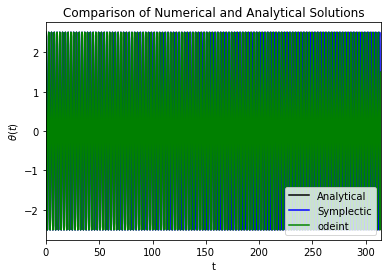

In [80]:
#Plot results

plt.plot(t,thetaAna,color='k',label='Analytical') #Analytical solution is black
plt.plot(t,thetaSym,color='b',label='Symplectic') # Symplectic solution is blue
#plt.plot(t,thetaEuler,color='g',label='Euler') # Euler solution is green
plt.plot(t,thetaSP,color='g',label='odeint')
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.title("Comparison of Numerical and Analytical Solutions")
plt.legend(loc=4)
plt.show()

In [81]:
def energy(u,theta,params):
    k = params["k"]
    return grav**2/k**2*(1/(2*k**2)*u**2-np.cos(theta))

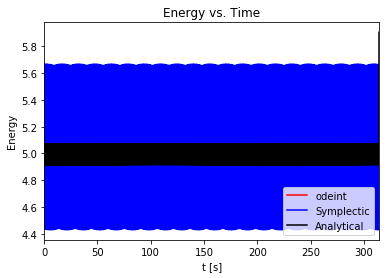

In [82]:
energyEuler = energy(uEuler,thetaEuler,params)
energySym = energy(uSym,thetaSym,params)
energyAna = energy(uAna,thetaAna,params)
energySP = energy(uSP,thetaSP,params)
  
#plt.plot(t,energyEuler,color='g',label='Euler')
plt.plot(t,energySP,color='r',label='odeint')
plt.plot(t,energySym,color='b',label='Symplectic')
plt.plot(t,energyAna,color='k',label='Analytical')

plt.xlabel('t [s]')
plt.ylabel('Energy')
plt.xlim(0,dt*nt)
plt.title("Energy vs. Time")
plt.legend(loc=4)
plt.show()

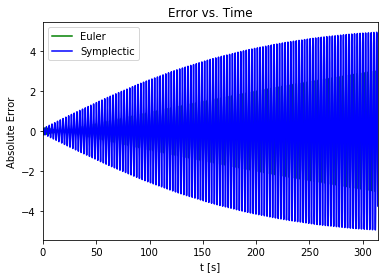

In [83]:
# Plot the error
errEuler = thetaEuler - thetaAna 
errSym = thetaSym - thetaAna
errSP = thetaSP - thetaAna

plt.plot(t,errEuler,color='g',label="Euler") # Euler function error is green
plt.plot(t,errSym,color='b',label="Symplectic") # Symplectic error is blue
#plt.plot(t,errSP,color='r',label="odeint")
plt.xlabel('t [s]')
plt.ylabel('Absolute Error')
plt.xlim(0,dt*nt)
plt.title("Error vs. Time")
plt.legend()
plt.show()

In [68]:
# Verify order of accuracy

j = np.linspace(0,7,20)
h = 2**(-j) # list of dt values

err1=np.zeros(h.size); err2=np.zeros(h.size); err3=np.zeros(h.size); err4=np.zeros(h.size); errSP=np.zeros(h.size)

for i in range(h.size):
    nt = int(time/h[i])
    tvec = np.linspace(t0,time,nt)
        
    thetaA = analytical(tvec,theta0,params)
    theta1,u1 = euler(tvec,h[i],theta0,u0,params)
    theta2,u2 = verlet(tvec,h[i],theta0,u0,params)
    theta3,u3 = symplectic(tvec,h[i],theta0,u0,3,params)
    theta4,u4 = symplectic(tvec,h[i],theta0,u0,4,params)
    
    sol = sp.integrate.odeint(deriv,[theta0,u0],tvec,args=(params["k"],0))
    thetaSP = sol[:,0]
    uSP = sol[:,1]
    
    # total error over time for each 
    error1 = theta1 - thetaA
    error2 = theta2 - thetaA
    error3 = theta3 - thetaA
    error4 = theta4 - thetaA
    errorSP = thetaSP - thetaA
    
    # Error at final time step
    #err1[i] = np.abs(error1[-1])
    #err2[i] = np.abs(error2[-1])
    #err3[i] = np.abs(error3[-1])
    #err4[i] = np.abs(error4[-1])
    
    # Integrate squared error over time
    err1[i] = np.sqrt(sp.integrate.simps(error1**2,tvec))
    err2[i] = np.sqrt(sp.integrate.simps(error2**2,tvec))
    err3[i] = np.sqrt(sp.integrate.simps(error3**2,tvec))
    err4[i] = np.sqrt(sp.integrate.simps(error4**2,tvec))
    errSP[i] = np.sqrt(sp.integrate.simps(errorSP**2,tvec))



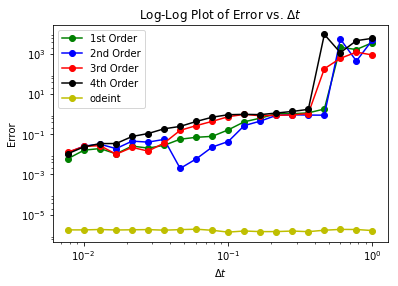

2.38137754577
2.23726481679
2.31454491768
2.51607351942


In [58]:
# loglog plot, Error vs 1/dt
plt.loglog(h,err1,'g-o',label="1st Order")
plt.loglog(h,err2,'b-o',label="2nd Order")
plt.loglog(h,err3,'r-o',label="3rd Order")
plt.loglog(h,err4,'k-o',label="4th Order")
plt.loglog(h,errSP,'y-o',label="odeint")
plt.xlabel(r'$\Delta t$')
plt.ylabel('Error')
plt.title(r"Log-Log Plot of Error vs. $\Delta t$")
plt.legend()
plt.show()

# find slope of loglog plot
slope1 = np.polyfit(np.log(h),np.log(err1),1)[0]
slope2 = np.polyfit(np.log(h),np.log(err2),1)[0]
slope3 = np.polyfit(np.log(h),np.log(err3),1)[0]
slope4 = np.polyfit(np.log(h),np.log(err4),1)[0]

print(slope1)
print(slope2)
print(slope3)
print(slope4)